In [2]:
import glob
import math
import ntpath
import os
import shutil
from pathlib import Path
import numpy as np
import pandas as pd

import mne

from mne.channels import read_custom_montage
from mne.epochs import concatenate_epochs

from mne import Epochs, pick_types, find_events, EpochsArray,create_info
from mne.io import concatenate_raws, read_raw_edf

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [3]:
data_path = Path(mne.datasets.sample.data_path(verbose=False))
sample_dir = data_path / 'MEG' / 'sample'
subjects_dir = data_path / 'subjects'

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')

raw_path = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')

#raw = mne.io.read_raw(raw_path)
#raw.pick_types(eeg=True, eog=True, stim=True).crop(tmax=60).load_data()

In [4]:
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True )
raw.crop(tmax=60.)

Opening raw data file C:\Users\AA086655\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

# Artifacts Visualisation

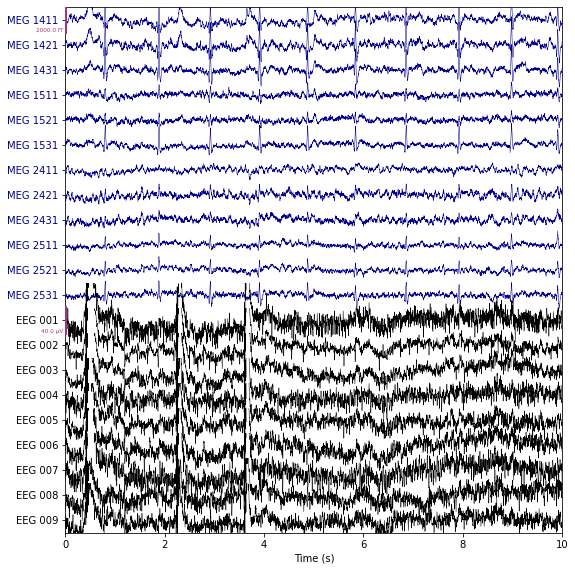

In [7]:
# pick some channels that clearly show heartbeats and blinks
regexp = r'(MEG [12][45][123]1|EEG 00.)'
artifact_picks = mne.pick_channels_regexp(raw.ch_names, regexp=regexp)
raw.plot(order=artifact_picks, n_channels=len(artifact_picks),
         show_scrollbars=False);

# Artifacts removal using ICA

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Loading data for 10 events and 601 original time points ...
0 bad epochs dropped
Applying baseli

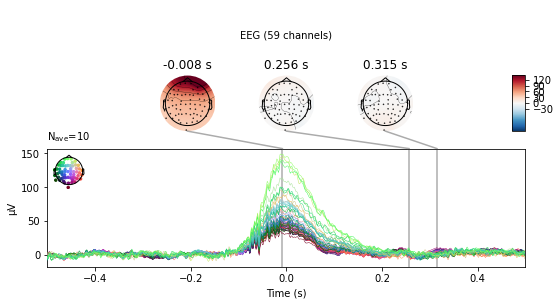

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


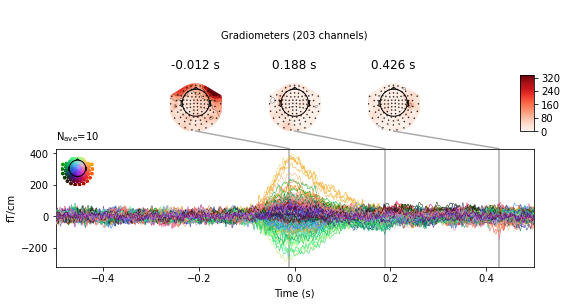

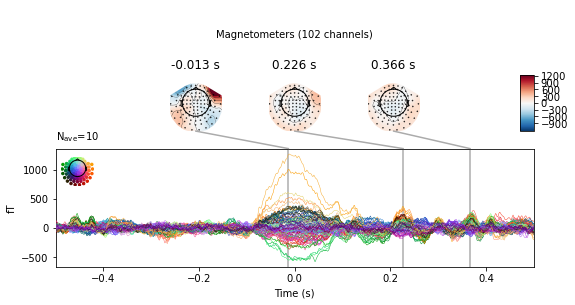

[<Figure size 576x302.4 with 7 Axes>,
 <Figure size 576x302.4 with 7 Axes>,
 <Figure size 576x302.4 with 7 Axes>]

In [8]:
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

# Power Spectrum Density for the Raw data

Effective window size : 3.410 (s)
Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


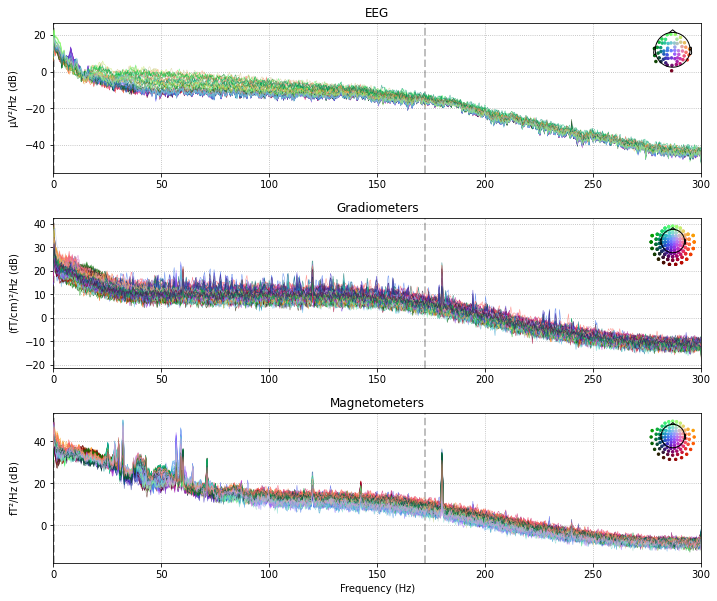

Effective window size : 3.410 (s)
Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


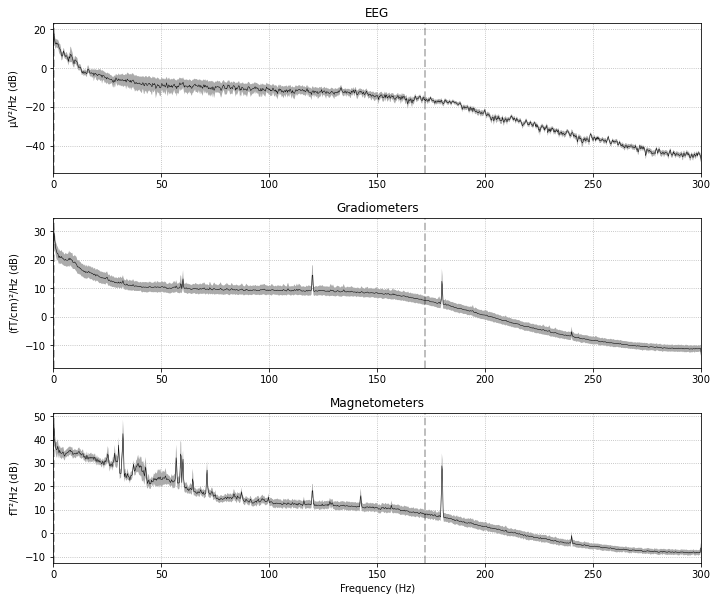

In [9]:
raw.plot_psd();
raw.plot_psd(average=True);

# Power Spectrum Density for the Filtered data

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1983 samples (3.302 sec)

Effective window size : 3.410 (s)
Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


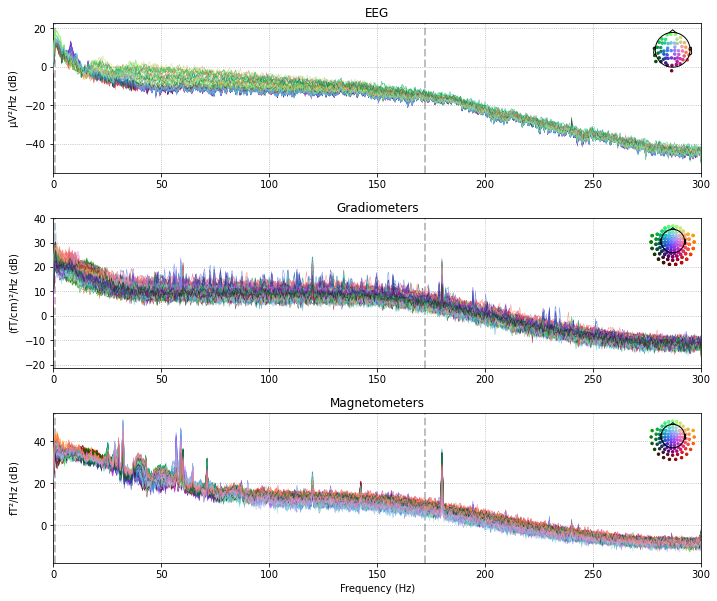

Effective window size : 3.410 (s)
Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


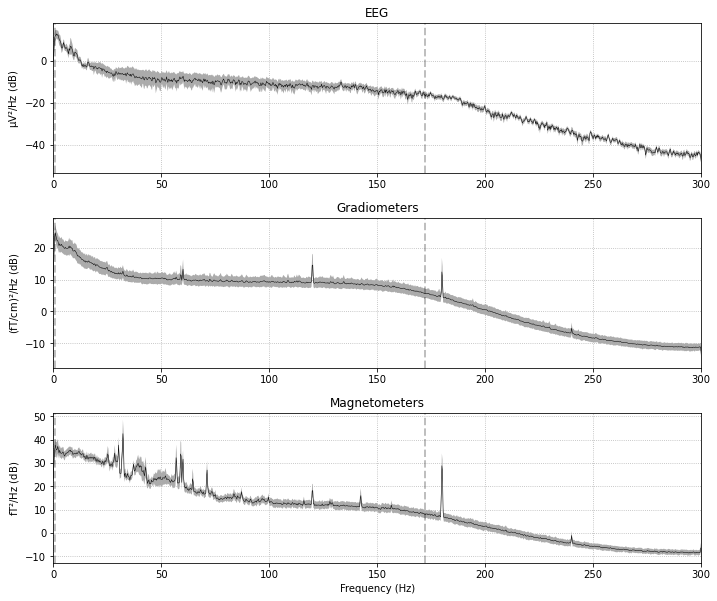

In [10]:
filt_raw = raw.copy()

filt_raw.load_data().filter(l_freq=1., h_freq=None)
filt_raw.plot_psd();
filt_raw.plot_psd(average=True);


# Independent Component Analysis

In [12]:
ica = mne.preprocessing.ICA(
    n_components=15,  # fit 5 ICA components
    fit_params=dict(tol=0.01)  # assume very early on that ICA has converged
)

ica.fit(inst=filt_raw)

# create epochs based on EOG events, find EOG artifacts in the data via pattern
# matching, and exclude the EOG-related ICA components
eog_epochs = mne.preprocessing.create_eog_epochs(raw=raw)
eog_components, eog_scores = ica.find_bads_eog(
    inst=eog_epochs,
    ch_name='EEG 001',  # a channel close to the eye
    threshold=1  # lower than the default threshold
)

ica.exclude = eog_components


ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(filt_raw)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.2s.
Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 sec)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
Creat

Method,fastica
Fit,61 iterations on raw data (36038 samples)
ICA components,15
Explained variance,60.8 %
Available PCA components,364
Channel types,"mag, grad, eeg"
ICA components marked for exclusion,—


# Plot the ICAs

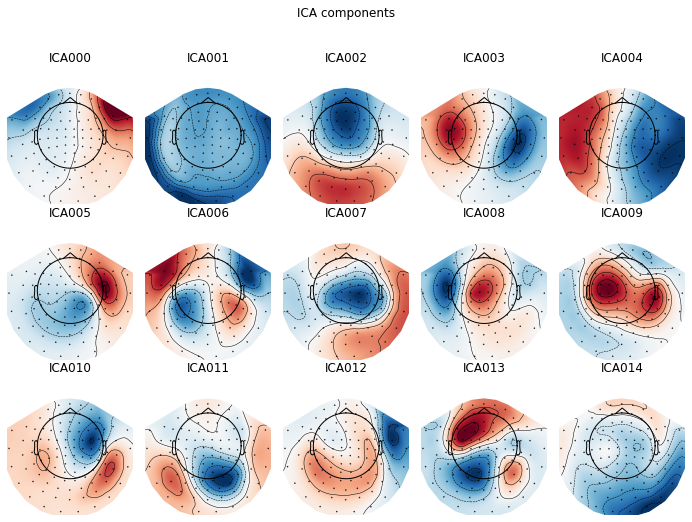

[<MNEFigure size 702x526.68 with 15 Axes>]

In [13]:
ica.plot_components()

Creating RawArray with float64 data, n_channels=16, n_times=36038
    Range : 25800 ... 61837 =     42.956 ...   102.956 secs
Ready.


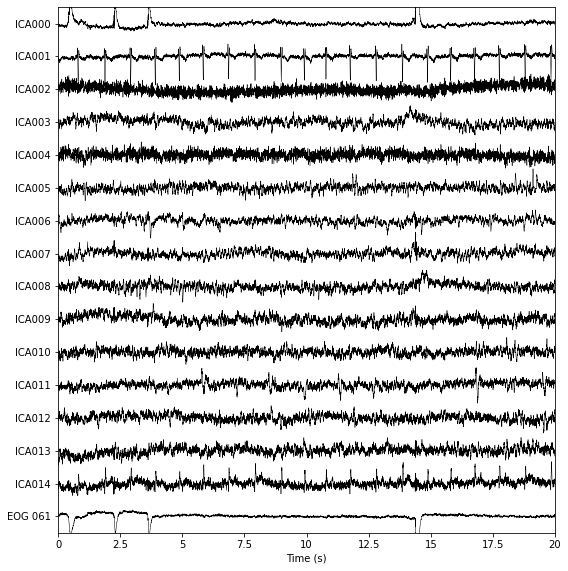

In [15]:
#raw.load_data()
ica.plot_sources(raw, show_scrollbars=False);

In [ ]:
ica.plot_properties(raw, picks=[0, 1])

# Excluding Artifact Components from the ICA 

In [16]:
# The first two component are irrelevent
ica.exclude = [0, 1] 

# Comparison of Signal before and after Artifacts removal

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


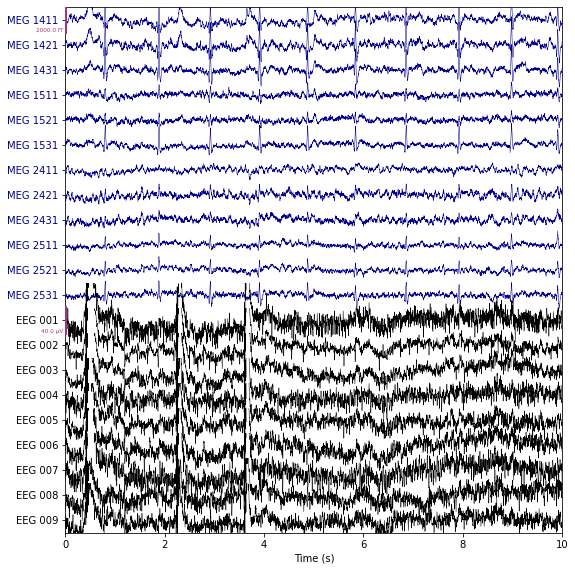

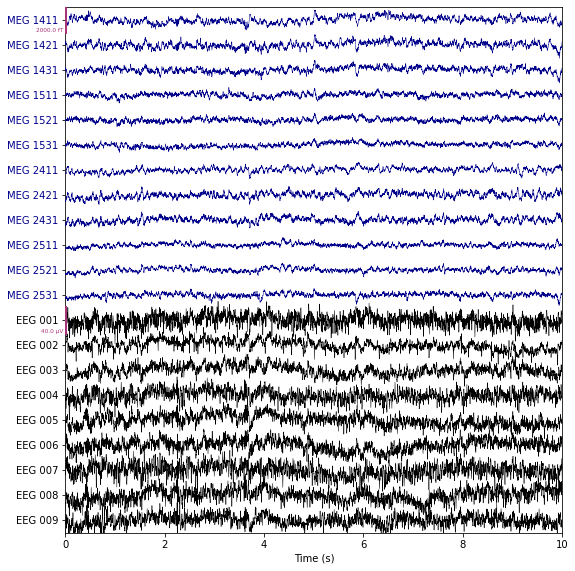

In [17]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

raw.plot(order=artifact_picks, n_channels=len(artifact_picks),
         show_scrollbars=False)
reconst_raw.plot(order=artifact_picks, n_channels=len(artifact_picks),
                 show_scrollbars=False);

In [18]:
ica.fit(reconst_raw)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 33.2s.


C:\Users\AA086655\.conda\envs\tf-gpu\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Method,fastica
Fit,1000 iterations on raw data (36038 samples)
ICA components,15
Explained variance,61.2 %
Available PCA components,364
Channel types,"mag, grad, eeg"
ICA components marked for exclusion,ICA000ICA003


# ICA after Artifacts removal

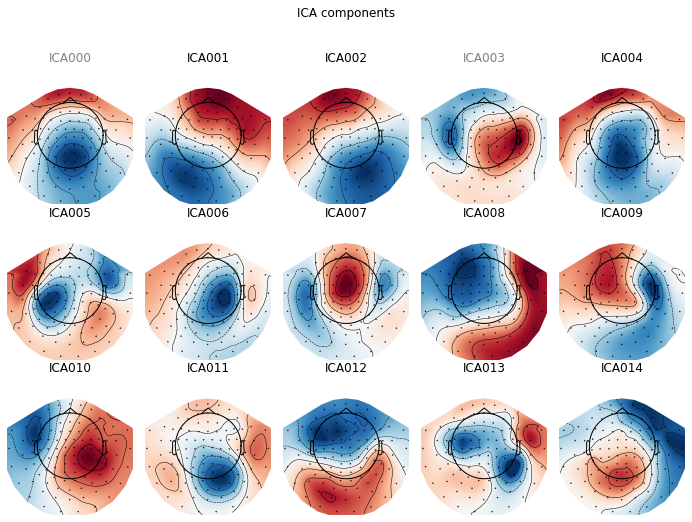

[<MNEFigure size 702x526.68 with 15 Axes>]

In [19]:
ica.plot_components()

Creating RawArray with float64 data, n_channels=16, n_times=36038
    Range : 25800 ... 61837 =     42.956 ...   102.956 secs
Ready.


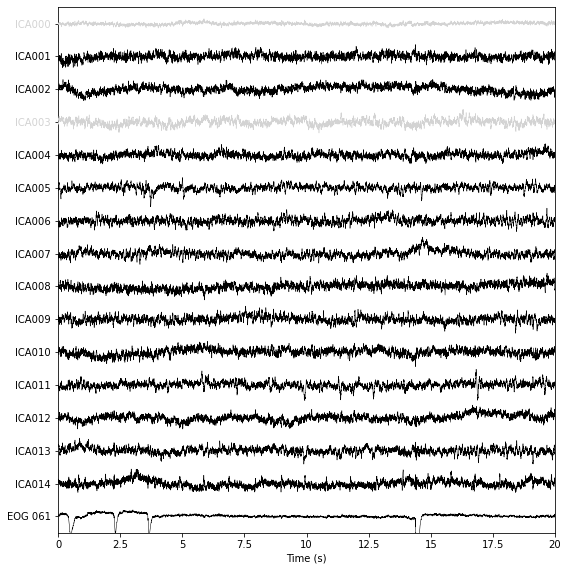

In [20]:
#reconst_raw.load_data()
ica.plot_sources(reconst_raw, show_scrollbars=False);